# HOTOSM TM Project 8301 validation

This notebook performs basic validation of data in the HOTOSM Taskin Manager Project #8301

OSM data export used for analysis is available at:


In [1]:
# SET MANUALLY after configuring the export
EXPORT_UID = '4d19a6bd-949d-48bc-8265-352c21468410'

print(f'https://export.hotosm.org/en/v3/exports/{EXPORT_UID}')

https://export.hotosm.org/en/v3/exports/4d19a6bd-949d-48bc-8265-352c21468410


In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt

import json
import requests
from datetime import datetime
from IPython.display import JSON, HTML
from zipfile import ZipFile
from tempfile import TemporaryFile
from pathlib import Path
from glob import glob

gpd.pd.set_option('display.max_rows', 500)

print('latest script run:', datetime.utcnow(), 'UTC')

def init_figure():

    fig = plt.figure(figsize=(5,6))
    ax = fig.add_subplot(1, 1, 1)
    gpd.read_file('clipping_boundary.geojson').plot(ax=ax, color='orange', alpha=0.5, edgecolor='black')
    return fig,ax

def dump_points(gdf, filename, show=True):
    """helper function for writing geojson and plots"""
    display(HTML(f'<pre><a href="{filename}">{filename}</pre></a>'))
    fig,ax = init_figure()
    gdf.plot(ax= ax,marker='.')
    if show:
        plt.show()
    with open(filename, 'w') as file:
        file.write(gdf.to_json())
    return fig,ax

# Latest data export status

In [3]:
q = requests.get(f'https://export.hotosm.org/api/jobs/{EXPORT_UID}')
export = json.loads(q.content.decode())

# pretty print some debug data
keep_fields = ['uid','name','description','osma_link','export_formats']
export = {field: export[field] for field in keep_fields}
print("Export tool info")
print("================")
print(json.dumps(export, indent=2))

uid = export['uid']
runs = requests.get(f'https://export.hotosm.org/api/runs?job_uid={uid}')
runs = runs.content.decode()
runs = json.loads(runs)

assert len(runs) > 0

sorted_runs = sorted(runs, key=lambda k: k['started_at']) 
latest_run = sorted_runs[-1]

if len(sorted_runs) > 1:
    assert sorted_runs[-1]['started_at'] > sorted_runs[-2]['started_at']
assert latest_run['status'] == 'COMPLETED'

# find the latest download link
export_download_url = None

for task in latest_run['tasks']:
    if task['name'] == 'shp':
        assert task['status'] == 'SUCCESS'
        export_download_url = 'https://' + task['download_urls'][0]['absolute_download_url']
        break
        
assert export_download_url is not None


print("Latest run info")
print("===============")
keep_fields = ['uid','started_at','status']
latest_run = {field: latest_run[field] for field in keep_fields}
print(json.dumps(latest_run, indent=2))

Export tool info
{
  "uid": "4d19a6bd-949d-48bc-8265-352c21468410",
  "name": "HOTOSM-TM-project-8301-validation-data",
  "description": "Data export for HOTOSM tasking manager project 8301 automated validation. Includes nodes with place tag",
  "osma_link": "http://osm-analytics.org/#/show/bbox:-73.9811021079999,-15.4582882329999,-70.3450719799999,-11.212293479/buildings/recency",
  "export_formats": [
    "geopackage",
    "osm_pbf",
    "shp"
  ]
}
Latest run info
{
  "uid": "56d96a61-e487-4f17-8355-b52d0c1c14f0",
  "started_at": "2020-04-22T07:24:17.378055Z",
  "status": "COMPLETED"
}


In [4]:
### download data and extract it form zip file 
### Also performs cast data into easier to work with
### datatypes.

resp = requests.get(export_download_url)
zip_file = TemporaryFile()
zip_file.write(resp.content)
archive = ZipFile(zip_file).extractall()

shapefiles = glob('*.shp')
assert len(shapefiles) == 1
shp_file = shapefiles[0]

points = gpd.read_file(shp_file)
assert len(points) != 0

# fix some column names. shapefiles have
# stange ways of being case sensitive
points = points.rename(columns = {
        'fixme_1': 'fixme',
        'FIXME': 'FIXME_1',
})
points = points.rename(columns = {'NAME': 'name'})
points = points.rename(columns = {'name_1': 'NAME_1'})


def cast(to_type, ndata=None):
    return lambda x: to_type(x) if x is not None else ndata

points['ele']    = points['ele'].apply(cast(float))
points['ELE_1']  = points['ELE_1'].apply(cast(float))
points['osm_id'] = points['osm_id'].apply(cast(int))
points['population'] = points['population'].apply(cast(float))

# get the list of columns, and remove all non-string columsn
cols = list(points.columns)
cols.remove('ele')
cols.remove('ELE_1')
cols.remove('osm_id')
cols.remove('population')
cols.remove('geometry')
for col in cols:    
    points[col] = points[col].apply(cast(str, None))


# Numbers of non-null values in each field

Informational values for convenience. Lists shows the total number or different unique values for each key in the dataset.

In [5]:
points.count()

osm_id        1717
comment          0
note             0
ele            130
population      56
name          1612
ELE_1            0
FIXME_1        113
source         527
fixme            0
descriptio       2
place         1717
NAME_1           0
geometry      1717
dtype: int64

# All different _place_ key values 

Manually sanity-check that the list below only has allowed values. It is the list of all values used in the AOI.

In [6]:
print(points.place.unique())

['city' 'suburb' 'village' 'town' 'hamlet' 'isolated_dwelling'
 'neighbourhood' 'square' 'state' 'region' 'locality' 'farm' 'city_block']


# Place Name Possibly Duplicated

Ther _may_ be dupliacate names. It is possible for multiple places to have the same name.

This lists _nearby_ duplicates by _name_: all points with the same name, what are close by to eachother.

The figure below also shows the search radius for context.

Adjacent points with duplicate name: 42
Adjacency criterion: 0.1 degrees of arc


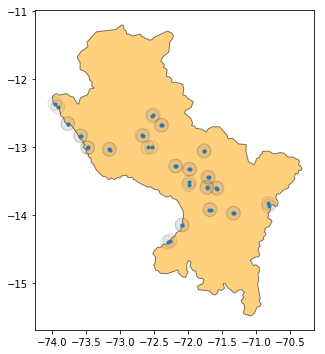

In [12]:

def find_adjacent_duplicates(points, radius):
    
    # all points with a name (empty names would all be duplicates)
    has_name = points.loc[points.name.isnull() == False]

    # keep=False means instad of 'first' or 'last' we mark all true or false.
    # i.e this does not drop any rows of data
    # we do this filtering now, so that we have less rows to iterate over
    dup = has_name.loc[has_name.name.duplicated(keep=False) == True]

    # calculate a search radiu around each point (degrees)
    
    buf = dup.geometry.buffer(radius)

    for idx, point in dup.iterrows():

        this_buffer = buf[idx]

        has_same_name     = dup['name'] == point['name']
        is_not_this_point = dup.index != idx
        is_nearby         = dup.within(this_buffer) 
        
        nearby_duplicates = dup[has_same_name & is_not_this_point & is_nearby]
        
        yield nearby_duplicates
        
radius = 0.1
adjacent_duplicates = gpd.pd.concat(find_adjacent_duplicates(points, radius));

print(f'Adjacent points with duplicate name:', len(adjacent_duplicates))
print(f'Adjacency criterion: {radius} degrees of arc') 
fig,ax = dump_points(adjacent_duplicates, 'adjacent_duplicates.geojson', show=False);
buf = adjacent_duplicates.geometry.buffer(radius)
buf.plot(ax=ax, alpha=0.1, edgecolor='black', color='grey')
plt.show()

# Place Name Dubious or Missing

All places shall have a 'name' attribute.

This lists all nodes with:

1. no 'name' attribute
2. a 'fixme'='name' attribute indicating name needs to be checked.

Places with uncertain name: 137


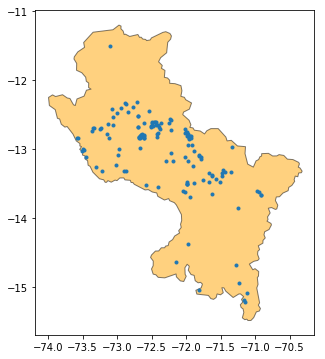

In [8]:
name_empty = points[(points.name.isnull()) | (points.FIXME_1 == 'name')]
print("Places with uncertain name:", len(name_empty))
dump_points(name_empty, 'name_fixme.geojson');

# Generic FIXME Points

There should be 0 nodes with a 'fixme' attribue.

Some are not remotely fixable, though. This lists points where 'fixme' is not 'name', but something more genereic, usually a human-readable string.

Places with generic fixme: 15


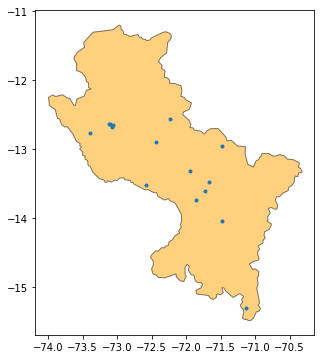

In [9]:
generic_fixme = points[~points.FIXME_1.isin(['name', None])]
print('Places with generic fixme:', len(generic_fixme))
dump_points(generic_fixme, 'generic_fixme.geojson');

# Uppercase ELE and NAME Fields are Prohibited 

There shall be 0 nodes with uppercase ELE or NAME fields.

Original import data had these, but have since been updated. These are unlikely to appear during the project.

In [10]:
has_uppercase_field = points[
    (points.ELE_1.isnull() == False) |
    (points.NAME_1.isnull() == False)
]

print("Points with uppercase ELE or NAME field:", len(has_uppercase_field))
if len(has_uppercase_field) > 0:
    dump_points(has_uppercase_field, 'has_uppercase_field.geojson');

Points with uppercase ELE or NAME field: 0


# Overlapping Nodes are Prohibited

There shall be 0 overlapping nodes.

In [11]:
geom_hash = points.geometry.x.apply(hash) + points.geometry.y.apply(hash)
print('Overlapping nodes:', len(geom_hash.unique()) - len(points))

Overlapping nodes: 0
